In [1]:
from neuralplayground.arenas import Sphere
from neuralplayground.agents import Stachenfeld2018, RatInASphere
from neuralplayground.backend import episode_based_training_loop
from neuralplayground.plotting.plot_utils import make_plot_rate_map
from neuralplayground.backend import SingleSim
from neuralplayground.comparison import GridScorer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from mpl_toolkits.mplot3d import Axes3D
from projection_agents import RatOnTangent, RatOnLogarithmicTangent
from scipy import interpolate

## Grid cells observed in spherical space - model training

In [2]:
simulation_id = "SR_rat_in_a_sphere"
agent_class = RatInASphere
env_class = Sphere
training_loop = episode_based_training_loop

N_SLICES = N_STACKS = 36

agent_params = {"discount":  0.9,
                "threshold": 1e-6,
                "lr_td":  1e-2,
                "n_slices": N_SLICES,
                "n_stacks": N_STACKS}

env_params = {"n_stacks": N_SLICES,
             "n_slices": N_STACKS,
             "gravity_mag": 0.15,
             "step_size": 0.1}

training_loop_params = {"t_episode": 1000, "n_episode": 1000}

In [3]:
sim_rat_sphere = SingleSim(simulation_id = simulation_id,
                agent_class = agent_class,
                agent_params = agent_params,
                env_class = env_class,
                env_params = env_params,
                training_loop = training_loop,
                training_loop_params = training_loop_params)

# sim_rat_sphere.run_sim("sim_model")

## Grid cells observed on horizontal tangent - model training

In [4]:
agent_params = {"room_width" : 2,
                "room_depth" : 2,
                "state_density" : 25.5}

env_params = {"n_stacks": 100,
             "n_slices": 100,
             "gravity_mag": 0.15,
             "step_size": 0.1}

agent_class = RatOnTangent
env_class = Sphere

sim_tangent = SingleSim(simulation_id = simulation_id,
                agent_class = agent_class,
                agent_params = agent_params,
                env_class = env_class,
                env_params = env_params,
                training_loop = training_loop,
                training_loop_params = training_loop_params)

sim_tangent.run_sim("ortho_projection")

## Grid cells observed on logarithmic tangent - model training

In [5]:
agent_params = {"room_width" : 3,
                "room_depth" : 3,
                "state_density" : 12}

env_params = {"n_stacks": 100,
             "n_slices": 100,
             "gravity_mag": 0.15,
             "step_size": 0.1}

agent_class = RatOnLogarithmicTangent
env_class = Sphere

sim_logtangent = SingleSim(simulation_id = simulation_id,
                agent_class = agent_class,
                agent_params = agent_params,
                env_class = env_class,
                env_params = env_params,
                training_loop = training_loop,
                training_loop_params = training_loop_params)

# sim_logtangent.run_sim("log_projection")

## Compile results

Load in trained models

In [6]:
agent, env, train_hist = sim_rat_sphere.load_results('sim_model')
orth_agent, _, _ = sim_tangent.load_results('ortho_projection')
log_agent, _, _ = sim_logtangent.load_results('log_projection')

Hyperparameters for analysis

In [7]:
eigen_vectors = [1,5,10,15,20,50]

Plotting utilities

In [8]:
def plot_on_3d_surface(ax, grid_cell, n_slices, n_stacks, heading=False):

    # Plot 3d-hemisphere
    phi = np.linspace(np.pi/2, np.pi, n_stacks)
    theta = np.linspace(0, 2*np.pi, n_slices)
    phi, theta = np.meshgrid(phi, theta)
    x = np.sin(phi)*np.cos(theta)
    y = np.sin(phi)*np.sin(theta)
    z = np.cos(phi)

    # Apply rate maps to colours
    norm = plt.Normalize(grid_cell.min(), grid_cell.max())
    ax.plot_surface(x,y,z, facecolors = plt.cm.jet(norm(grid_cell.T)), linewidth=0, antialiased=False, alpha=0.8)
    if heading :
        ax.set_title("Euclidean grid cells")
    return ax

def plot_combined_results(ax, eig_number, grid_cell, orth_grid_cell, log_grid_cell, corr_dict, heading = False):

    plot_on_3d_surface(ax[0], grid_cell, N_SLICES, N_STACKS, heading)
    make_plot_rate_map(grid_cell, ax[1], "Spherical coordinates" if heading else "", "Azimuthal", "Polar", "Firing rate")
    make_plot_rate_map(orth_grid_cell, ax[2], "Orthogonal projection" if heading else "", "x", "y", "Firing rate")
    make_plot_rate_map(log_grid_cell, ax[3], "Logarithmic projection" if heading else "", "x", "y", "Firing rate")
    plot_rotation_correlation_curve(ax[4], corr_dict, heading=heading)

def plot_rotation_correlation_curve(ax, corr_dict, heading=False):
    
    angles = list(corr_dict.keys())
    correlation_values = list(corr_dict.values())

    f = interpolate.interp1d(angles, correlation_values, kind='cubic', fill_value="extrapolate")

    # Create a denser set of x values for a smoother curve
    x_dense = np.linspace(0, 180, 1000)

    # Calculate interpolated y values
    y_dense = f(x_dense)

    # Create the plot
    ax.plot(x_dense, y_dense, '-', label='Interpolated')
    ax.plot(angles, correlation_values, 'ro', label='Original data')
    ax.set_xlabel('Angle (degrees)')
    ax.set_ylabel('Correlation Value')
    if heading:
        ax.set_title('Rotation Correlation Values')
    ax.grid(True)
    #ax.legend()

    # Add x-axis ticks for original angles
    ax.set_xticks(angles)


In [9]:
def compile_results(grid_cells, orth_grid_cells, log_grid_cells, eig_numbers):

    fig, axes = plt.subplots(len(eig_numbers), 5, figsize=(20, 24))
    GridScorer_Stachenfeld2018 = GridScorer(agent.n_stacks + 1)


    for idx, x in enumerate(eig_numbers):
        axes[idx,0].axis('off')
        axes[idx,0] = fig.add_subplot(len(eig_numbers), 5, 5*idx + 1, projection = '3d')
        axes[idx,0].view_init(80, -90)
        _, grid_field_props = GridScorer_Stachenfeld2018.get_scores(grid_cells[idx])
        plot_combined_results(axes[idx], x, grid_cells[idx], orth_grid_cells[idx], log_grid_cells[idx], grid_field_props['rotationCorrVals'], heading = idx == 0)
        #fig.supytitle(f"Eigenvector: {x}", (2*idx + 1.)/(2*len(eig_numbers)))
    # plt.subplots_adjust(bottom=0.5)
    plt.show()

C:\Users\Muhammad Sahal\OneDrive\Documents\Honours\Research\NeuralPlayground\neuralplayground\comparison\metrics.py:120: RuntimeWarning: invalid value encountered in sqrt
  mapStd = np.sqrt((sumOfSquares_x * N) - sums_x**2)
C:\Users\Muhammad Sahal\OneDrive\Documents\Honours\Research\NeuralPlayground\neuralplayground\comparison\metrics.py:122: RuntimeWarning: invalid value encountered in divide
  A = np.squeeze(mapCovar / mapStd / mapStd[::-1, :, :][:, ::-1, :][:, :, :])
C:\Users\Muhammad Sahal\OneDrive\Documents\Honours\Research\NeuralPlayground\neuralplayground\comparison\metrics.py:120: RuntimeWarning: invalid value encountered in sqrt
  mapStd = np.sqrt((sumOfSquares_x * N) - sums_x**2)
C:\Users\Muhammad Sahal\OneDrive\Documents\Honours\Research\NeuralPlayground\neuralplayground\comparison\metrics.py:122: RuntimeWarning: invalid value encountered in divide
  A = np.squeeze(mapCovar / mapStd / mapStd[::-1, :, :][:, ::-1, :][:, :, :])
C:\Users\Muhammad Sahal\OneDrive\Documents\Honours

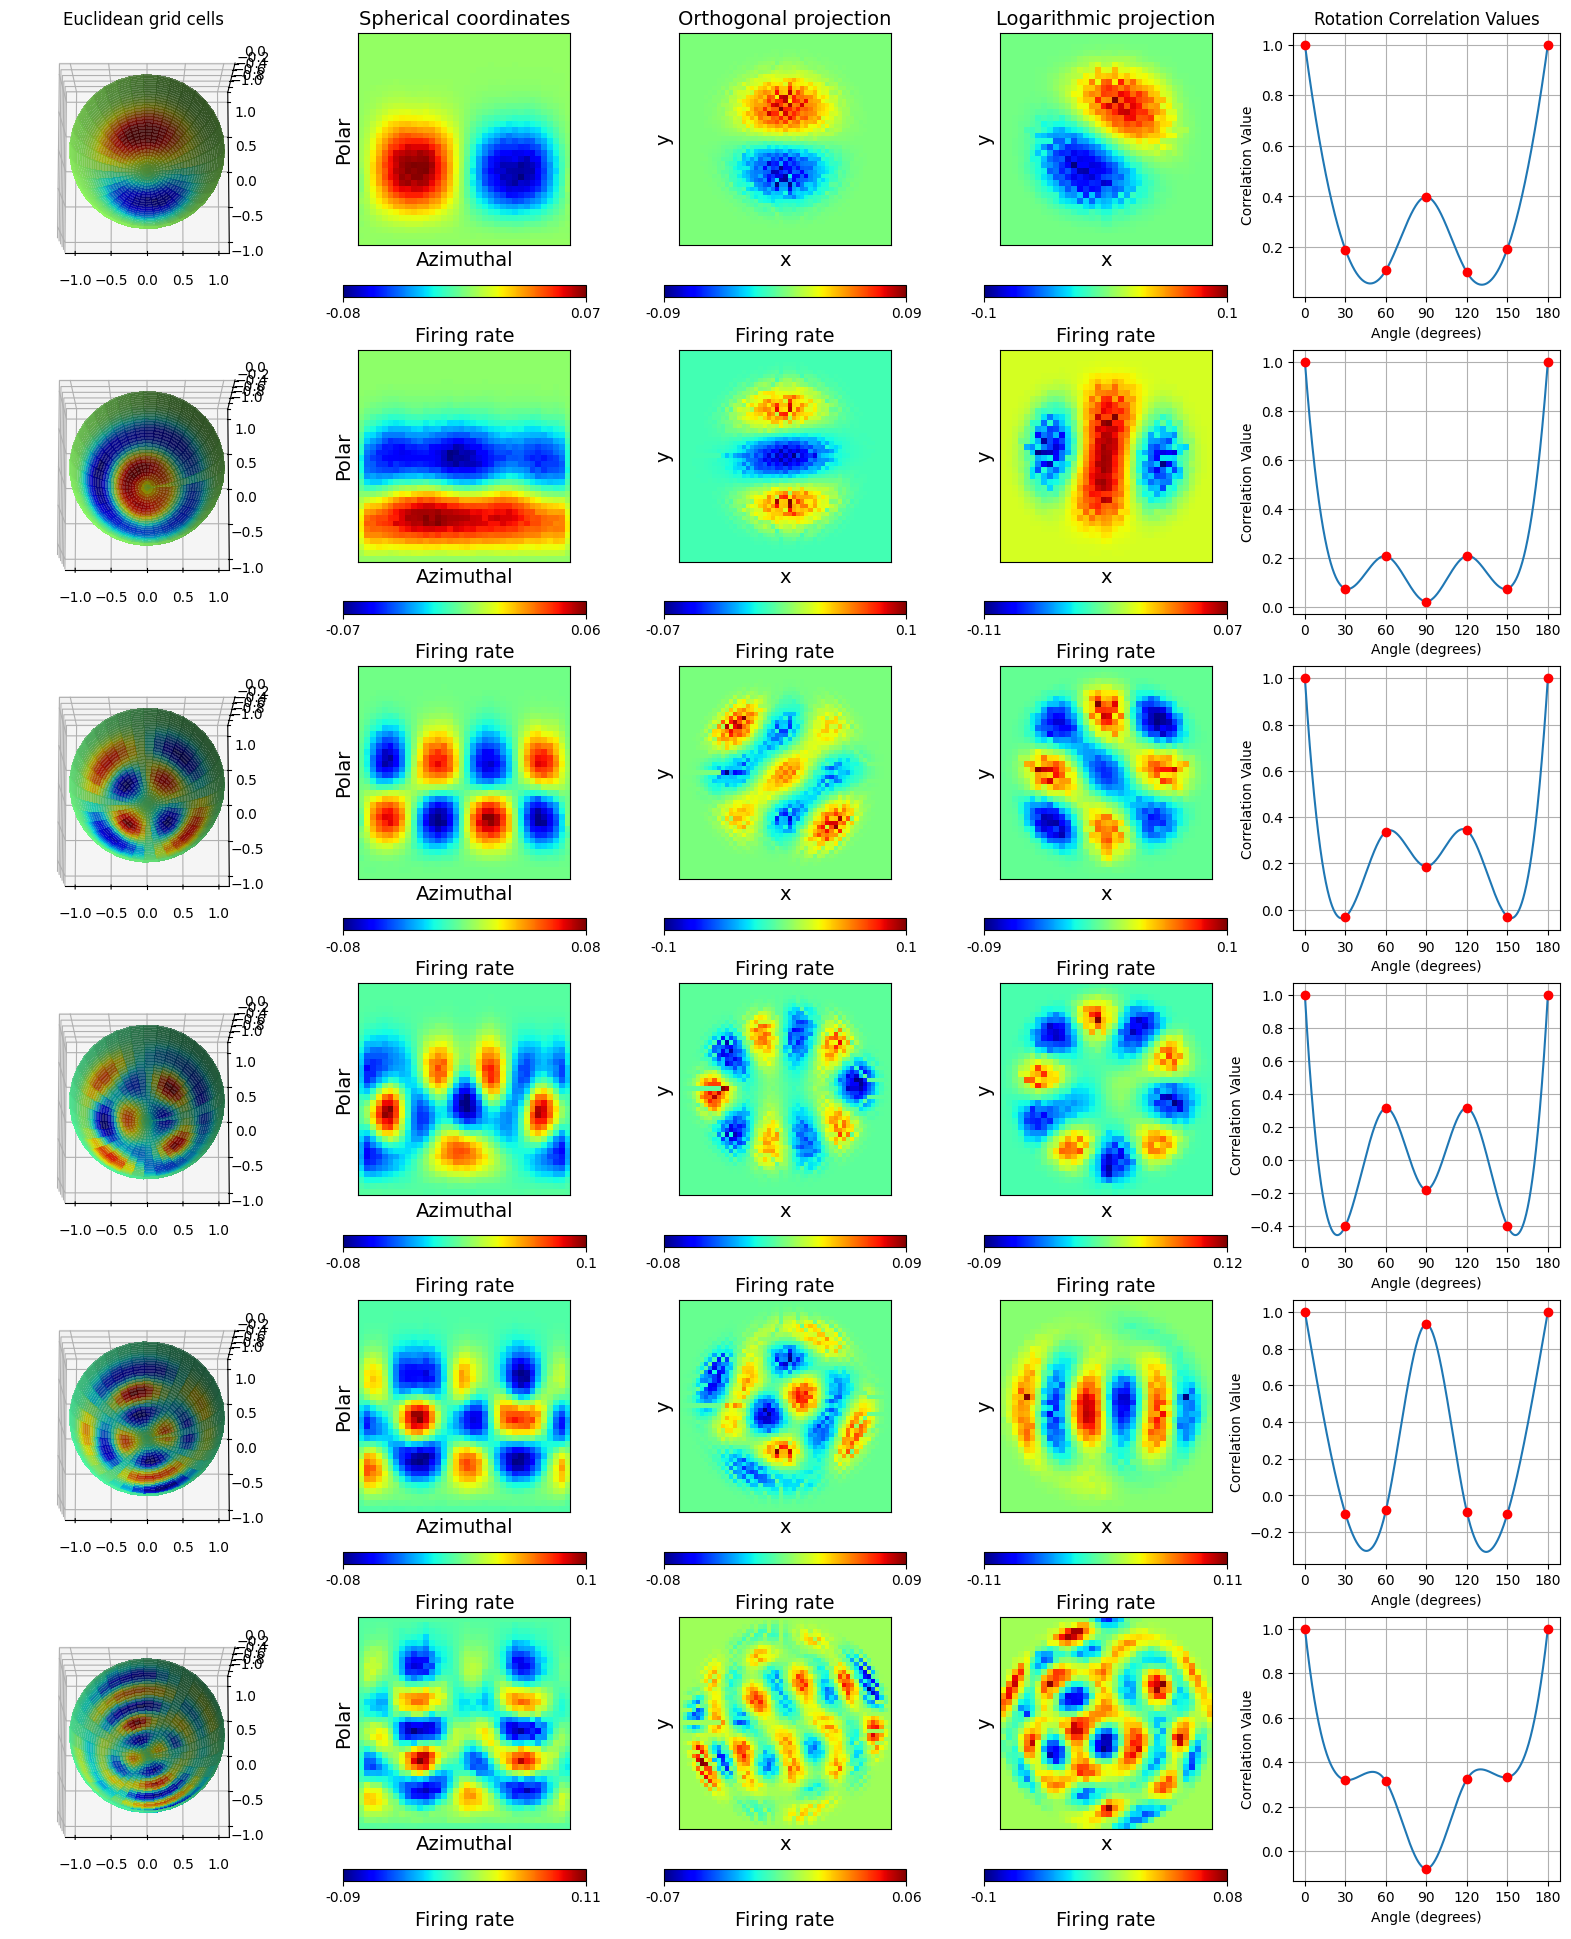

In [10]:
grid_cells = agent.get_rate_map_matrix(agent.srmat, eigen_vectors)
orth_grid_cells = orth_agent.get_rate_map_matrix(orth_agent.srmat, eigen_vectors)
log_grid_cells = log_agent.get_rate_map_matrix(log_agent.srmat, eigen_vectors)

compile_results(grid_cells, orth_grid_cells, log_grid_cells, eigen_vectors)

In [ ]:
trained_agent, env, training_hist = sim.load_results('spherical_results')
gridness_scores = []
for eig in range(trained_agent.srmat.shape[0]):
    r_out_im, _= trained_agent.get_rate_map_matrix(trained_agent.srmat, eigen_vector=eig)
    GridScorer_Stachenfeld2018 = GridScorer(trained_agent.n_stacks + 1)
    # GridScorer_Stachenfeld2018.plot_grid_score(r_out_im=r_out_im, plot= True)
    sac, grid_field_props = GridScorer_Stachenfeld2018.get_scores(r_out_im)
    gridness_scores.append(grid_field_props['gridscore'])
fig, ax = plt.subplots(1,1)
sns.histplot(gridness_scores, ax=ax, bins=20, kde=True, color='green'), ax.set_title("Histogram of gridness scores")
plt.show()

In [ ]:
# # trained_agent, env, training_hist = sim.load_results('tangential_results')
# gridness_scores = []
# for eig in range(trained_agent.srmat.shape[0]):
#     r_out_im, _= trained_agent.get_rate_map_matrix(trained_agent.srmat, eigen_vector=eig)
#     GridScorer_Stachenfeld2018 = GridScorer(trained_agent.room_width + 1)
#     # GridScorer_Stachenfeld2018.plot_grid_score(r_out_im=r_out_im, plot= True)
#     sac, grid_field_props = GridScorer_Stachenfeld2018.get_scores(r_out_im)
#     gridness_scores.append(grid_field_props['gridscore'])
# fig, ax = plt.subplots(1,1)
# sns.histplot(gridness_scores, ax=ax, bins=20, kde=True, color='green'), ax.set_title("Histogram of gridness scores")
# plt.show()

In [ ]:
# import os
# import cv2

# current_dir = os.getcwd()
# frames_dir = 'frames'
# abs_frames_dir = os.path.join(current_dir, frames_dir)
# if not os.path.exists(abs_frames_dir):
#     os.makedirs(abs_frames_dir)
# for i in range(1000):
#     env.render(history_length=i+1, save_dir=os.path.join(abs_frames_dir, f'frame_{i:03d}.png'))

# image_folder = 'frames'
# video_name = 'video_gravity_2.avi'

# images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
# frame = cv2.imread(os.path.join(image_folder, images[0]))
# height, width, layers = frame.shape

# video = cv2.VideoWriter(video_name, 0, 20, (width,height))

# for image in images:
#     video.write(cv2.imread(os.path.join(image_folder, image)))

# cv2.destroyAllWindows()
# video.release()